# Homework 2: Introduction to PyTorch

PyTorch is a framework for creating and training neural networks. It's one of the most common neural network libraries, alongside TensorFlow, and is used extensively in both academia and industry. PyTorch was designed for simplicity -- The code you write is the code that is executed, unlike TensorFlow, and there's very little overhead in terms of reused code. In this homework, we'll explore the basic operations within PyTorch, and we'll design a neural network to classify images.

Let's start by importing the libraries that we'll need:

In [1]:
import torch
import torchvision
import torch.nn as nn

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

If you can't import torch, go to www.pytorch.org and follow the instructions there for downloading PyTorch. You can select CUDA Version as None, as we won't be working with any GPUs on this homework.

## PyTorch: Tensors

In PyTorch, data is stored as multidimensional arrays, called tensors. Tensors are very similar to numpy's ndarrays, and they support many of the same operations. We can define tensors by explicity setting the values, using a python list:

In [2]:
A = torch.tensor([[1, 2], [4, -3]])
B = torch.tensor([[3, 1], [-2, 3]])

print("A:")
print(A)

print('\n')

print("B:")
print(B)

A:
tensor([[ 1,  2],
        [ 4, -3]])


B:
tensor([[ 3,  1],
        [-2,  3]])


Just like numpy, PyTorch supports operations like addition, multiplication, transposition, dot products, and concatenation of tensors.

In [3]:
print("Sum of A and B:")
print(torch.add(A, B))

print('\n')

print("Elementwise product of A and B:")
print(torch.mul(A, B))

print('\n')

print("Matrix product of A and B:")
print(torch.matmul(A, B))

print('\n')

print("Transposition of A:")
print(torch.t(A))

print('\n')

print("Concatenation of A and B in the 0th dimension:")
print(torch.cat((A, B), dim=0))

print('\n')

print("Concatenation of A and B in the 1st dimension:")
print(torch.cat((A, B), dim=1))

Sum of A and B:
tensor([[4, 3],
        [2, 0]])


Elementwise product of A and B:
tensor([[ 3,  2],
        [-8, -9]])


Matrix product of A and B:
tensor([[-1,  7],
        [18, -5]])


Transposition of A:
tensor([[ 1,  4],
        [ 2, -3]])


Concatenation of A and B in the 0th dimension:
tensor([[ 1,  2],
        [ 4, -3],
        [ 3,  1],
        [-2,  3]])


Concatenation of A and B in the 1st dimension:
tensor([[ 1,  2,  3,  1],
        [ 4, -3, -2,  3]])


PyTorch also has tools for creating large tensors automatically, without explicity specifying the values:

In [4]:
print("3x4x5 Tensor of Zeros:")
print(torch.zeros(3, 4, 5))

print('\n')

print("5x5 Tensor with random elements sampled from a standard normal distrubtion:")
print(torch.randn(5, 5))

print('\n')

print("Tensor created from a range:")
print(torch.arange(10))

3x4x5 Tensor of Zeros:
tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])


5x5 Tensor with random elements sampled from a standard normal distrubtion:
tensor([[ 1.4570,  1.4069, -0.2078, -0.6265, -0.4712],
        [-0.5027, -0.5896, -0.8094,  0.2571, -0.9131],
        [ 0.3588,  0.7210, -0.4957,  0.2125,  1.0537],
        [-0.2950,  1.0451,  0.6155, -0.4495, -2.0734],
        [-0.3386, -0.1611, -0.9596, -1.3002,  0.3977]])


Tensor created from a range:
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


Now, use PyTorch tensors to complete the following computation:

Create a tensor of integers from the range 0 to 99, inclusive. Add 0.5 to each element in the tensor, and square each element of the result. Then, negate each element of the tensor, and apply the exponential to each element (i.e., change each element x into e^x). Now, sum all the elements of the tensor and print your result.

If you're right, you should get something very close to $$\frac{1}{2} \cdot \sqrt{\pi} \approx 0.8862 .$$

In [5]:
val = torch.arange(100).float()

### <YOUR CODE HERE> ####

val = torch.add(val, 0.5)
val = torch.pow(val, 2)
val = torch.mul(val, -1)
val = torch.exp(val)
val = torch.sum(val)

### </YOUR CODE HERE> ###

print(val)

tensor(0.8861)


To do this, you'll need to use the PyTorch documentation at https://pytorch.org/docs/stable/torch.html. Luckily, PyTorch has very well-written docs.

## PyTorch: Autograd

Autograd is PyTorch's automatic differentiation tool: It allows us to compute gradients by keeping track of all the operations that have happened to a tensor. In the context of neural networks, we'll interpret these gradient calculations as backpropagating a loss through a network.

To understand how autograd works, we first need to understand the idea of a __computation graph__. A computation graph is a directed, acyclic graph (DAG) that contains a blueprint of a sequence of operations. For a neural network, these computations consist of matrix multiplications, bias additions, ReLUs, softmaxes, etc. Nodes in this graph consist of the operations themselves, while the edges represent tensors that flow forward along this graph.

In PyTorch, the creation of this graph is __dynamic__. This means that tensors themselves keep track of their own computational history, and this history is build as the tensors flow through the network; this is unlike TensorFlow, where an external controller keeps track of the entire computation graph. This dynamic creation of the computation graph allows for lots of cool control-flows that are not possible (or at least very difficult) in TensorFlow.

![alt text](https://raw.githubusercontent.com/pytorch/pytorch/master/docs/source/_static/img/dynamic_graph.gif)
<center>_Dynamic computation graphs are cool!_</center>
_ _

Let's take a look at a simple computation to see what autograd is doing. First, let's create two tensors and add them together. To signal to PyTorch that we want to build a computation graph, we must set the flag requires_grad to be True when creating a tensor.

In [6]:
a = torch.tensor([1, 2], dtype=torch.float, requires_grad=True)
b = torch.tensor([8, 3], dtype=torch.float, requires_grad=True)

c = a + b

Now, since a and b are both part of our computation graph, c will automatically be added:

In [7]:
c.requires_grad

True

When we add a tensor to our computation graph in this way, our tensor now has a grad_fn attribute. This attribute tells autograd how this tensor was generated, and what tensor(s) this particular node was created from.

In the case of c, its grad_fn is of type AddBackward1, PyTorch's notation for a tensor that was created by adding two tensors together:

In [8]:
c.grad_fn

Every grad_fn has an attribute called next_functions: This attribute lets the grad_fn pass on its gradient to the tensors that were used to compute it.

In [9]:
c.grad_fn.next_functions

((<AccumulateGrad at 0x7f94bc365278>, 0),
 (<AccumulateGrad at 0x7f94bc3657b8>, 0))

If we extract the tensor values corresponding to each of these functions, we can see a and b! 

In [10]:
print(c.grad_fn.next_functions[0][0].variable)
print(c.grad_fn.next_functions[1][0].variable)

tensor([1., 2.], requires_grad=True)
tensor([8., 3.], requires_grad=True)


In this way, autograd allows a tensor to record its entire computational history, implicitly creating a computational graph -- All dynamically and on-the-fly!

## PyTorch: Modules and Parameters

In PyTorch, collections of operations are encapsulated as __modules__. One way to visualize a module is to take a section of a computational graph and collapse it into a single node. Not only are modules useful for encapsulation, they have the ability to keep track of tensors that are contained inside of them: To do this, simply wrap a tensor with the class torch.nn.Parameter.

To define a module, we must subclass the type torch.nn.Module. In addition, we must define a _forward_ method that tells PyTorch how to traverse through a module.

For example, let's define a logistic regression module. This module will contain two parameters: The weight vector and the bias. Calling the _forward_ method will output a probability between zero and one.

In [11]:
class LogisticRegression(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.weight = nn.Parameter(torch.randn(10))
        self.bias = nn.Parameter(torch.randn(1))
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, vector):
        return self.sigmoid(torch.dot(vector, self.weight) + self.bias)
        

Note that we have fixed the dimension of our weight to be 10, so our module will only accept 10-dimensional data.

We can now create a random vector and pass it through the module:

In [12]:
module = LogisticRegression()
vector = torch.randn(10)
output = module(vector)

In [13]:
output

tensor([0.5088], grad_fn=<SigmoidBackward>)

Now, say that our loss function is mean-squared-error and our target value is 1. We can then write our loss as:

In [14]:
loss = (output - 1) ** 2

In [15]:
loss

tensor([0.2413], grad_fn=<PowBackward0>)

To minimize this loss, we just call loss.backward(), and all the gradients will be computed for us! Note that wrapping a tensor as a Parameter will automatically set requires_grad = True.

In [16]:
loss.backward()

In [17]:
print(module.weight.grad)
print(module.bias.grad)

tensor([-0.1252, -0.0185,  0.0425,  0.0626, -0.1287, -0.0310, -0.1274,  0.1981,
        -0.1647,  0.0950])
tensor([-0.2455])


## Fully-connected Networks for Image Classification

Using this knowledge, you will create a neural network in PyTorch for image classification on the CIFAR-10 dataset.

In [18]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
trainset = [(np.asarray(image) / 256, label) for image, label in trainset]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4096, shuffle=True)

val_and_test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
val_and_test_set = [(np.asarray(image) / 256, label) for image, label in val_and_test_set]

valset = val_and_test_set[:5000]
valset = (
    torch.stack([torch.tensor(pair[0]) for pair in valset]),
    torch.tensor([pair[1] for pair in valset])
)
testset = val_and_test_set[5000:]
testset = (
    torch.stack([torch.tensor(pair[0]) for pair in testset]),
    torch.tensor([pair[1] for pair in testset])
)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


CIFAR-10 consists of 32 x 32 color images, each corresponding to a unique class indicating the object present within the image. Here are a few examples:

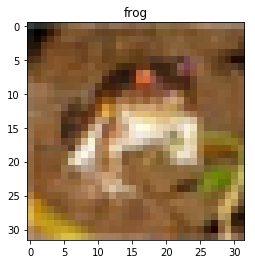

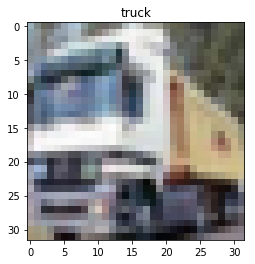

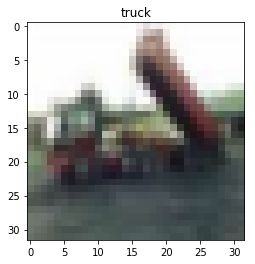

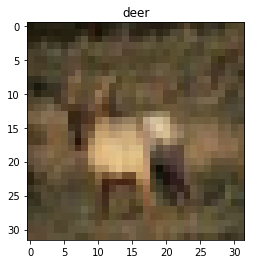

In [19]:
for image, label in trainset[:4]:
    plt.title(classes[label])
    plt.imshow(image)
    plt.show()

We've already split the dataset into training, validation, and test sets for you. 

**Your assignment is to create and train a neural network that properly classifies images in the CIFAR-10 dataset. You should achieve above 40% classification accuracy on the test set in order to receive full credit on this homework.**

We've given you some starter code to achieve this task, but the rest is up to you. Google is your friend -- Looking things up on the PyTorch docs and on StackOverflow will be helpful.

To turn in the assignment, convert this notebook to a PDF (File -> Download As -> PDF via LaTeX) and submit to Gradescope.

In [20]:
class NeuralNet(nn.Module):
    
    def __init__(self, layer_sizes):
        
        super().__init__()
        
        ### <YOUR CODE HERE> ####
        
        layers = []
        for a, b in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Linear(a, b))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        self.sequential = nn.Sequential(*layers)
        
        ### </YOUR CODE HERE> ###
        
    def forward(self, images):
        
        ### <YOUR CODE HERE> ####
        
        assert images.shape[1] == 32 * 32 * 3
        return self.sequential(images)
    
        ### </YOUR CODE HERE> ###
        

In [21]:
def reshape(images):
    '''
    Reshapes a set of images of the shape (batch_size, width, height, channels)
    into the proper shape (batch_size, width * height * channels) that the model can accept.
    '''
    return images.reshape(images.shape[0], -1).float()
    

In [22]:
EPOCHS = 35
LEARNING_RATE = 0.005
HIDDEN_LAYER_SIZES = [32 * 32 * 3, 100, 100, 50, 20, 10]

net = NeuralNet(HIDDEN_LAYER_SIZES)
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

print(net)

for epoch in range(EPOCHS):
    
    average_loss = 0
    
    for images, labels in trainloader:
        
        images = reshape(images)
        output = net(images)
        loss = loss_fn(output, labels)
        
        ### <YOUR CODE HERE> ####
        # Zero gradients, call .backward(), and step the optimizer.
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        ### </YOUR CODE HERE> ###
        
        average_loss += loss.item()
        
    average_loss /= len(trainloader)
    
    val_output = net(reshape(valset[0]))
    val_loss = loss_fn(val_output, valset[1]).item()
    
    print("(epoch, train_loss, val_loss) = ({0}, {1}, {2})".format(epoch, average_loss, val_loss))


NeuralNet(
  (sequential): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=20, bias=True)
    (7): ReLU()
    (8): Linear(in_features=20, out_features=10, bias=True)
  )
)
(epoch, train_loss, val_loss) = (0, 2.2817354385669413, 2.2186696529388428)
(epoch, train_loss, val_loss) = (1, 2.1673462574298563, 2.115046262741089)
(epoch, train_loss, val_loss) = (2, 2.089391286556537, 2.0638701915740967)
(epoch, train_loss, val_loss) = (3, 2.062041245974027, 2.0455214977264404)
(epoch, train_loss, val_loss) = (4, 2.0317473594958964, 2.005185842514038)
(epoch, train_loss, val_loss) = (5, 1.9827335889522846, 1.9519456624984741)
(epoch, train_loss, val_loss) = (6, 1.923720277272738, 1.9005545377731323)
(epoch, train_loss, val_loss) = (7, 1.8635750275391798, 1.

In [23]:
### Here, we test the overall accuracy of our model. ###
test_output = net(reshape(testset[0]))
test_maxes = torch.argmax(test_output, dim=1)
print("Test accuracy:", torch.sum(test_maxes == testset[1]).item() / float(test_maxes.shape[0]))

Test accuracy: 0.443
